In [1]:
from os import listdir
from math import log
import string
import re
from time import time
from statistics import mean, median
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# Код из практической части

In [2]:
def get_files_data(path):
    data = []
    for file in listdir(path):
        review = []    
        with open(path+file, encoding='ansi') as f:
            for line in f:
                review.append(line)
        data.append("".join(review))
    return data

In [3]:
pos_train_path = './aclImdb/train/pos/'
neg_train_path = './aclImdb/train/neg/'
pos_test_path = './aclImdb/test/pos/'
neg_test_path = './aclImdb/test/neg/'
punct = string.punctuation + '…–—‘“‚„«»'

In [4]:
# get train data
train_pos = get_files_data(pos_train_path)
train_neg = get_files_data(neg_train_path)
len(train_pos), len(train_neg)

(12500, 12500)

In [5]:
# get test data
test_pos = get_files_data(pos_test_path)
test_neg = get_files_data(neg_test_path)
len(train_pos), len(train_neg)

(12500, 12500)

In [6]:
def prep(data):
    new_data = []
    for idx, str in enumerate(data):
        new_str = []
        str = str.lower()
        for c in str:
            if c in punct:
                new_str.append(' '+c+' ')
            else:
                new_str.append(c)
        new_data.append("".join(new_str))
    return new_data

In [7]:
train_pos_prep = prep(train_pos)
train_neg_prep = prep(train_neg)

In [8]:
test_pos_prep = prep(test_pos)
test_neg_prep = prep(test_neg)

In [9]:
def tokenize(data):
    new_data = []
    for str in data:
        tokens = []
        for idx, word in enumerate(str.split()):
            if word in punct:
                try:
                    tokens[-1] += word
                except:
                    tokens.append(word)
            else:
                tokens.append(word)
        new_data.append(tokens)
    return new_data

In [10]:
train_pos_tok = tokenize(train_pos_prep)
train_neg_tok = tokenize(train_neg_prep)

In [11]:
test_pos_tok = tokenize(test_pos_prep)
test_neg_tok = tokenize(test_neg_prep)

In [12]:
def get_ngrams(tokens, ngram_range):
    return [" ".join(tokens[idx:idx+i]) 
            for i in range(ngram_range[0],ngram_range[1]+1) 
            for idx in range(len(tokens)-i+1)]

In [13]:
def count(pos_tok, neg_tok, nb='ber', ngram_range=(1,1), alpha=1):
    
    # returns dicts pos_idx and neg_idx that match token and number of occurrences 
    # dicts are already smoothed 
    pos_idx = defaultdict(lambda: alpha)
    neg_idx = defaultdict(lambda: alpha)
    
    if nb == 'ber':
        #сount only one occurrence of token in review for Bernoulli Naive Bayes
        for rev in pos_tok:
            for token in set(get_ngrams(rev, ngram_range)):
                pos_idx[token] += 1

        for rev in neg_tok:
            for token in set(get_ngrams(rev, ngram_range)):
                neg_idx[token] += 1
    
    elif nb == 'mul':
        # count every occurance of token for Multinomial Naive Bayes
        for rev in pos_tok:
            for token in get_ngrams(rev, ngram_range):
                pos_idx[token] += 1

        for rev in neg_tok:
            for token in get_ngrams(rev, ngram_range):
                neg_idx[token] += 1
    else:
        print("Error")
    
    return pos_idx, neg_idx

In [14]:
# number of positive, negative and total reviews
train_pos_total, train_neg_total = len(train_pos_tok), len(train_neg_tok)
dict_total = train_pos_total + train_neg_total

In [15]:
class BerNB():
    def __init__(self):
        pass

    def fit(self, pos_idx, neg_idx, alpha=1):
        pos_probs = defaultdict(lambda: alpha/(train_pos_total+alpha*2))
        neg_probs = defaultdict(lambda: alpha/(train_neg_total+alpha*2))

        for k, v in pos_idx.items():
            pos_probs[k] = v/(train_pos_total+alpha*2)

        for k, v in neg_idx.items():
            neg_probs[k] = v/(train_neg_total+alpha*2)

        unique_words = sorted(list(set(pos_probs.keys())|set(neg_probs.keys())))

        self.trained_data = {k: [log(pos_probs[k]),
                        log(1-pos_probs[k]),
                        log(neg_probs[k]),
                        log(1-neg_probs[k])] for k in unique_words}

        self.pos_log_prior = log(train_pos_total) - log(dict_total)
        self.neg_log_prior = log(train_neg_total) - log(dict_total)
        
        # precoumputing negative probabilities for faster computation of Bernoulli Naive Bayes
        self.prior_pos_proba = sum([self.trained_data[k][1] for k in self.trained_data])
        self.prior_neg_proba = sum([self.trained_data[k][3] for k in self.trained_data])

    def predict(self, data, ngram_range=(1,1)):
        preds = []
        for text in data:
            pred_pos = self.prior_pos_proba
            for token in get_ngrams(text, ngram_range):
                if token in self.trained_data:
                    pred_pos = pred_pos - self.trained_data[token][1] + self.trained_data[token][0]
            pred_pos += self.pos_log_prior

            pred_neg = self.prior_neg_proba
            for token in get_ngrams(text, ngram_range):
                if token in self.trained_data:
                    pred_neg = pred_neg - self.trained_data[token][3] + self.trained_data[token][2]
            pred_neg += self.neg_log_prior

            preds.append(int(pred_pos > pred_neg))
        return preds

In [16]:
def accuracy(truth, preds):
    score = [int(t==p) for t,p in zip(truth, preds)]
    return sum(score)/len(score)

In [17]:
class MulNB():
    def __init__(self):
        pass
    
    def fit(self, pos_idx, neg_idx, alpha=1):
        unique_words = sorted(list(set(pos_idx.keys())|set(neg_idx.keys())))

        train_pos_feat_total = sum([pos_idx[k] for k in unique_words])
        train_neg_feat_total = sum([neg_idx[k] for k in unique_words])
        
        self.trained_data = {k: [log(pos_idx[k]) - log(train_pos_feat_total),
                    log(neg_idx[k]) - log(train_neg_feat_total)] for k in unique_words}

        self.pos_log_prior = log(train_pos_total / dict_total)
        self.neg_log_prior = log(train_neg_total / dict_total)
    
    def predict(self, data, ngram_range=(1,1)):
        preds = []
        for text in data:
            pred_pos = 0
            for word in get_ngrams(text, ngram_range):
                if word in self.trained_data:
                    pred_pos += self.trained_data[word][0]
            pred_pos += self.pos_log_prior

            pred_neg = 0
            for word in get_ngrams(text, ngram_range):
                if word in self.trained_data:
                    pred_neg += self.trained_data[word][1]
            pred_neg += self.neg_log_prior

            preds.append(int(pred_pos > pred_neg))
        return preds

# Код для запуска моделей и сохранения результатов

In [18]:
def test_model(mode='ber', count_mode='ber', ngram_range=(1,1), min_cnt=0, max_df=1.0, alpha=1):    
    print('Ngram range: %s min_cnt: %d max_df: %.1f alpha: %.1f' %(ngram_range, min_cnt, max_df, alpha))
    
    if count_mode == 'ber':
        print('Counting without repeats...\t\t\t\t', end='')
    elif count_mode == 'mul':
        print('Counting with repeats...\t\t\t\t', end='')
    start = time()        
    pos_idx, neg_idx = count(train_pos_tok, train_neg_tok, count_mode, ngram_range, alpha)
    end = time()
    print('Counted in %.2f sec,' %(end-start))
        
    if min_cnt or max_df<1:
        tmp_pos_idx = defaultdict(lambda: 1)
        for k,v in pos_idx.items():
            if v>min_cnt+1 and v<max_df*train_pos_total:
                tmp_pos_idx[k] = v
        tmp_neg_idx = defaultdict(lambda: 1)
        for k,v in neg_idx.items():
            if v>min_cnt+1 and v<max_df*train_neg_total:
                tmp_neg_idx[k] = v
        pos_idx = tmp_pos_idx
        neg_idx = tmp_neg_idx
    
    if mode == 'ber':
        print("Training Bernoulli\t\t\t\t\t", end="")
        model = BerNB()
        
    elif mode == 'mul':
        print("Training Multinomial\t\t\t\t\t", end="")
        model = MulNB()
        
    start = time()
    model.fit(pos_idx, neg_idx, alpha)
    end = time()
    print('Fitted in %.2f sec' %(end-start))

    start = time()
    preds = model.predict(train_pos_tok+train_neg_tok, ngram_range)
    end = time()
    acc = accuracy([1]*12500+[0]*12500, preds)
    print('Predicted for train in %.2f sec Accuracy: %f' %(end-start, acc))
    if mode == 'ber': 
        score_train = ('Bernoulli ngram_range:{} min_cnt:{} max_df:{} alpha:{}'.format(ngram_range, min_cnt, max_df, alpha), acc)
    elif mode == 'mul':
        score_train = ('Multinomial ngram_range:{} min_cnt:{} max_df:{}alpha:{}'.format(ngram_range, min_cnt, max_df, alpha), acc)

    start = time()
    preds = model.predict(test_pos_tok+test_neg_tok, ngram_range)
    end = time()
    acc = accuracy([1]*12500+[0]*12500, preds)
    print('Predicted for test in %.2f sec Accuracy: %f' %(end-start, acc))
    if mode == 'ber': 
        score_test = ('Bernoulli ngram_range:{} min_cnt:{} max_df:{}alpha:{}'.format(ngram_range, min_cnt, max_df, alpha), acc)
    elif mode == 'mul':
        score_test = ('Multinomial ngram_range:{} min_cnt:{} max_df:{}alpha:{}'.format(ngram_range, min_cnt, max_df, alpha), acc)
    print()
    
    return score_train, score_test

In [19]:
def plot_res(train_data, test_data, labels):
    plt.figure(figsize=(15,8))


    plt.subplot(121)
    plt.hlines(ber_baseline[0][1], 0, len(labels), 'r', 'solid')
    plt.hlines(mul_baseline[0][1], 0, len(labels), 'b', 'solid')
    plt.plot(list(map(str,labels)), list(train_data.values())[::2], 'r--', label='Bernoulli')
    plt.plot(list(map(str,labels)), list(train_data.values())[1::2], 'b--', label='Multinomial')
    plt.xlabel('N-gram range')
    plt.ylabel('Accuracy')
    plt.ylim((0.7, 1.01))
    plt.title('Train')
    plt.legend()
    plt.grid(True)

    plt.subplot(122)
    plt.hlines(ber_baseline[1][1], 0, len(labels), 'r', 'dashed')
    plt.hlines(mul_baseline[1][1], 0, len(labels), 'b', 'solid')
    plt.plot(list(map(str,labels)), list(test_data.values())[::2], 'r--', label='Bernoulli')
    plt.plot(list(map(str,labels)), list(test_data.values())[1::2], 'b--', label='Multinomial')
    plt.xlabel('N-gram range')
    plt.ylabel('Accuracy')
    plt.ylim((0.7, 1.0))
    plt.title('Test')
    plt.legend()
    plt.grid(True)
    plt.show()

# Исследовательская часть

Сначала сохраним baseline показатели для Bernoulli NB и Multinomial NB

In [20]:
ber_baseline = test_model('ber', 'ber')
mul_baseline = test_model('mul', 'mul')

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0 alpha: 1.0
Counting without repeats...				Counted in 2.01 sec,
Training Bernoulli					Fitted in 1.37 sec
Predicted for train in 6.14 sec Accuracy: 0.907240
Predicted for test in 5.89 sec Accuracy: 0.780640

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0 alpha: 1.0
Counting with repeats...				Counted in 1.87 sec,
Training Multinomial					Fitted in 1.00 sec
Predicted for train in 4.79 sec Accuracy: 0.937280
Predicted for test in 4.59 sec Accuracy: 0.819400



###### Тестирование n-грамм

In [21]:
def plot_(train_data, test_data, labels, ngrams):
    plt.figure(figsize=(15,8))
    n = len(ngrams)
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    plt.subplot(121)
    plt.hlines(ber_baseline[0][1], 0, n, 'r', 'dashed', label='Bernoulli')
    plt.hlines(mul_baseline[0][1], 0, n, 'b', 'solid', label='Multinomial')
    for idx, l in enumerate(labels):
        plt.plot(list(map(str,ngrams)), list(train_data.values())[idx*n*2:(idx+1)*n*2:2], 'r--', c=colors[idx*2], label=l)
        plt.plot(list(map(str,ngrams)), list(train_data.values())[idx*n*2+1:(idx+1)*n*2:2], 'b-', c=colors[idx*2+1], label=l)
    #plt.xlabel('N-gram range')
    plt.ylabel('Accuracy')
    plt.ylim((0.7, 1.01))
    plt.title('Train')
    plt.legend()
    plt.grid(True)

    plt.subplot(122)
    plt.hlines(ber_baseline[1][1], 0, n, 'r', 'dashed')
    plt.hlines(mul_baseline[1][1], 0, n, 'b', 'solid')
    for idx, l in enumerate(labels):
        plt.plot(list(map(str,ngrams)), list(test_data.values())[idx*n*2:(idx+1)*n*2:2], 'r--', c=colors[idx*2])
        plt.plot(list(map(str,ngrams)), list(test_data.values())[idx*n*2+1:(idx+1)*n*2:2], 'b-', c=colors[idx*2+1])
    #plt.xlabel('N-gram range')
    plt.ylabel('Accuracy')
    plt.ylim((0.7, 1.0))
    plt.title('Test')
    plt.grid(True)
    plt.show()

1.Словарь может состоять не только из униграмм (одиночных слов), но и n-грамм (n подряд
идущих слов). Добавить в словарь биграммы (пары подряд идущих слов) – помогает ли их
добавление улучшить результат и насколько? Помогает ли добавление триграмм? Нужно
ли оставлять униграммы или достаточно использовать только биграммы и триграммы? А
при n>3?

In [22]:
ngrams = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3), (3,4), (4,4)]
ngram_train = Counter()
ngram_test = Counter()
for ngram_range in ngrams:
    res = test_model('ber', 'ber', ngram_range)
    ngram_train[res[0][0]] = res[0][1]
    ngram_test[res[1][0]] = res[1][1]
    res = test_model('mul', 'mul', ngram_range)
    ngram_train[res[0][0]] = res[0][1]
    ngram_test[res[1][0]] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 2.08 sec,
Training Bernoulli					Fitted in 1.18 sec
Predicted for train in 6.52 sec Accuracy: 0.907240
Predicted for test in 5.84 sec Accuracy: 0.780640

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 2.06 sec,
Training Multinomial					Fitted in 1.30 sec
Predicted for train in 5.58 sec Accuracy: 0.937280
Predicted for test in 4.96 sec Accuracy: 0.819400

Ngram range: (1, 2) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 6.42 sec,
Training Bernoulli					Fitted in 13.10 sec
Predicted for train in 17.78 sec Accuracy: 0.990800
Predicted for test in 15.93 sec Accuracy: 0.832160

Ngram range: (1, 2) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 5.69 sec,
Training Multinomial					Fitted in 9.63 sec
Predicted for train in 15.04 sec Accuracy: 0.995720
Predicted for test in 14.83 sec Accuracy: 0.855760

Ngram range: (1, 3) min_cnt: 0 max_df: 1.

In [23]:
ngram_train.most_common(5)

[('Bernoulli ngram_range:(3, 3) min_cnt:0 max_df:1.0', 1.0),
 ('Bernoulli ngram_range:(3, 4) min_cnt:0 max_df:1.0', 1.0),
 ('Multinomial ngram_range:(3, 4) min_cnt:0 max_df:1.0', 1.0),
 ('Multinomial ngram_range:(4, 4) min_cnt:0 max_df:1.0', 1.0),
 ('Multinomial ngram_range:(3, 3) min_cnt:0 max_df:1.0', 0.99996)]

In [24]:
ngram_test.most_common(5)

[('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0', 0.87936),
 ('Multinomial ngram_range:(1, 3) min_cnt:0 max_df:1.0', 0.87192),
 ('Multinomial ngram_range:(3, 3) min_cnt:0 max_df:1.0', 0.86932),
 ('Multinomial ngram_range:(3, 4) min_cnt:0 max_df:1.0', 0.86856),
 ('Multinomial ngram_range:(2, 2) min_cnt:0 max_df:1.0', 0.86784)]

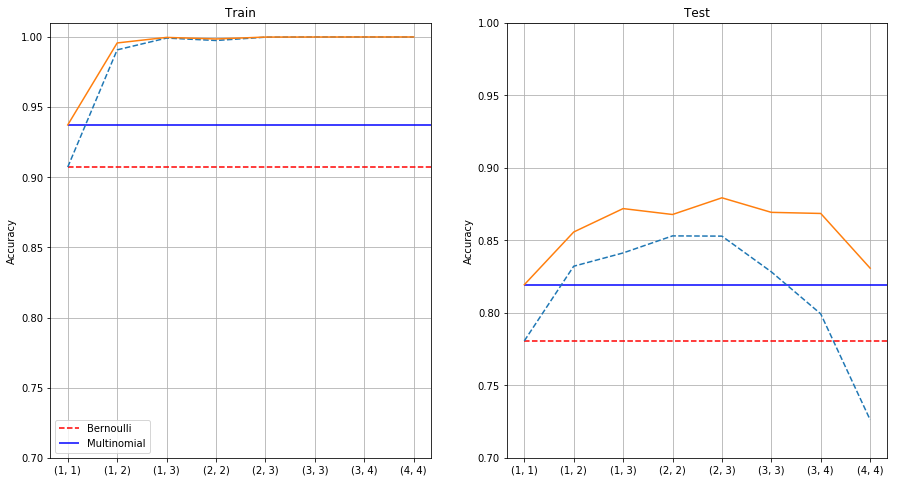

In [25]:
plot_(ngram_train, ngram_test, [''], ngrams)

##### Вывод
Биграммы и триграммы улушают точность на обучающей и тестовых выборках. Использование n-грамм c n>3 приводит к переобучению.  Модель только с биграммами и триграммами показала себя лучше, чем модель с униграммами.

2.Оценки $P(w_i|c_j)$ для низкочастотных слов недостоверны. Например, если слово
встретилось только 2 раза и оба в положительных отзывах – это может быть случайность.
Если оно встретилось 1000 раз и только в положительных отзывах – это уже скорее
закономерность. Попробуйте удалить из словаря слова, которые встретились < min_cnt раз.
Помогает ли это улучшить качество для униграммной модели? А для биграммной? Какое
значение min_cnt оптимально в каждом случае?

In [26]:
min_cnts = [1,2,3,4,5,10,100,1000]
min_cnt_train = Counter()
min_cnt_test = Counter()
for min_cnt in min_cnts:
    for ngram_range in [(1,1), (2,2), (2,3)]:  
        res = test_model('ber', 'ber', ngram_range, min_cnt)
        min_cnt_train[res[0][0]] = res[0][1]
        min_cnt_test[res[1][0]] = res[1][1]
        
        res = test_model('mul', 'mul', ngram_range, min_cnt)
        min_cnt_train[res[0][0]] = res[0][1]
        min_cnt_test[res[1][0]] = res[1][1]

Ngram range: (1, 1) min_cnt: 1 max_df: 1.0
Counting without repeats...				Counted in 1.86 sec,
Training Bernoulli					Fitted in 0.29 sec
Predicted for train in 5.35 sec Accuracy: 0.885600
Predicted for test in 5.21 sec Accuracy: 0.782280

Ngram range: (1, 1) min_cnt: 1 max_df: 1.0
Counting with repeats...				Counted in 1.78 sec,
Training Multinomial					Fitted in 0.23 sec
Predicted for train in 3.98 sec Accuracy: 0.773840
Predicted for test in 3.91 sec Accuracy: 0.660320

Ngram range: (2, 2) min_cnt: 1 max_df: 1.0
Counting without repeats...				Counted in 3.46 sec,
Training Bernoulli					Fitted in 1.26 sec
Predicted for train in 7.29 sec Accuracy: 0.985400
Predicted for test in 6.91 sec Accuracy: 0.865000

Ngram range: (2, 2) min_cnt: 1 max_df: 1.0
Counting with repeats...				Counted in 3.06 sec,
Training Multinomial					Fitted in 1.66 sec
Predicted for train in 6.47 sec Accuracy: 0.973280
Predicted for test in 6.12 sec Accuracy: 0.821280

Ngram range: (2, 3) min_cnt: 1 max_df: 1.0
Cou

In [27]:
min_cnt_train.most_common(5)

[('Bernoulli ngram_range:(2, 3) min_cnt:1 max_df:1.0', 0.99292),
 ('Multinomial ngram_range:(2, 3) min_cnt:1 max_df:1.0', 0.99056),
 ('Bernoulli ngram_range:(2, 2) min_cnt:1 max_df:1.0', 0.9854),
 ('Bernoulli ngram_range:(2, 3) min_cnt:2 max_df:1.0', 0.98132),
 ('Multinomial ngram_range:(2, 3) min_cnt:2 max_df:1.0', 0.97712)]

In [28]:
min_cnt_test.most_common(5)

[('Bernoulli ngram_range:(2, 3) min_cnt:1 max_df:1.0', 0.87944),
 ('Bernoulli ngram_range:(2, 3) min_cnt:2 max_df:1.0', 0.8764),
 ('Bernoulli ngram_range:(2, 3) min_cnt:3 max_df:1.0', 0.87584),
 ('Bernoulli ngram_range:(2, 3) min_cnt:4 max_df:1.0', 0.87204),
 ('Bernoulli ngram_range:(2, 3) min_cnt:5 max_df:1.0', 0.87032)]

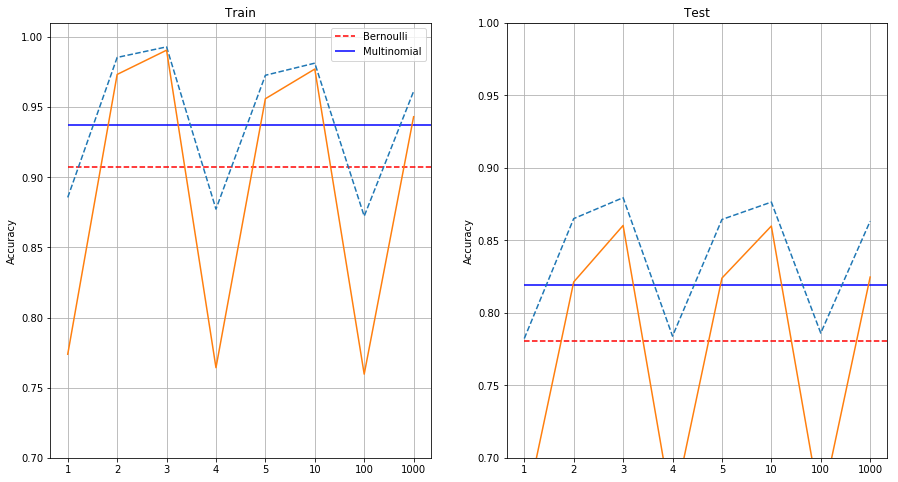

In [29]:
plot_(min_cnt_train, min_cnt_test, [''], min_cnts)

Сравните отсечку по document frequency и term frequency. Для этого Нарисуйте график
зависимости точности от размера словаря. Подберите значение порога так, чтобы получить
одинаковый размер словаря для каждого из вариантов.

In [30]:
min_dfs = [.4, .5, .6, .7, .8, .9, 1.]
ngrams = [(1,1), (2,2), (2,3)]
min_df_train = Counter()
min_df_test = Counter()
for max_df in min_dfs:
    for ngram_range in ngrams:  
        res = test_model('ber', 'ber', ngram_range, 0, max_df)
        min_df_train[res[0][0]] = res[0][1]
        min_df_test[res[1][0]] = res[1][1]
        
        res = test_model('mul', 'mul', ngram_range, 0, max_df)
        min_df_train[res[0][0]] = res[0][1]
        min_df_test[res[1][0]] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 0.4
Counting without repeats...				Counted in 1.86 sec,
Training Bernoulli					Fitted in 1.12 sec
Predicted for train in 4.73 sec Accuracy: 0.694000
Predicted for test in 4.57 sec Accuracy: 0.585040

Ngram range: (1, 1) min_cnt: 0 max_df: 0.4
Counting with repeats...				Counted in 1.76 sec,
Training Multinomial					Fitted in 1.07 sec
Predicted for train in 4.11 sec Accuracy: 0.763440
Predicted for test in 3.94 sec Accuracy: 0.608960

Ngram range: (2, 2) min_cnt: 0 max_df: 0.4
Counting without repeats...				Counted in 3.39 sec,
Training Bernoulli					Fitted in 9.45 sec
Predicted for train in 8.71 sec Accuracy: 0.995760
Predicted for test in 7.41 sec Accuracy: 0.820800

Ngram range: (2, 2) min_cnt: 0 max_df: 0.4
Counting with repeats...				Counted in 3.03 sec,
Training Multinomial					Fitted in 7.84 sec
Predicted for train in 7.54 sec Accuracy: 0.995160
Predicted for test in 6.51 sec Accuracy: 0.811640

Ngram range: (2, 3) min_cnt: 0 max_df: 0.4
Cou

In [31]:
min_df_train.most_common(5)

[('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:0.6', 0.99996),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:0.7', 0.99992),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:0.8', 0.99992),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:0.9', 0.99992),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0', 0.99992)]

In [32]:
min_df_test.most_common(5)

[('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:0.7', 0.87948),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:0.8', 0.87948),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:0.9', 0.87948),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0', 0.87936),
 ('Multinomial ngram_range:(2, 2) min_cnt:0 max_df:1.0', 0.86784)]

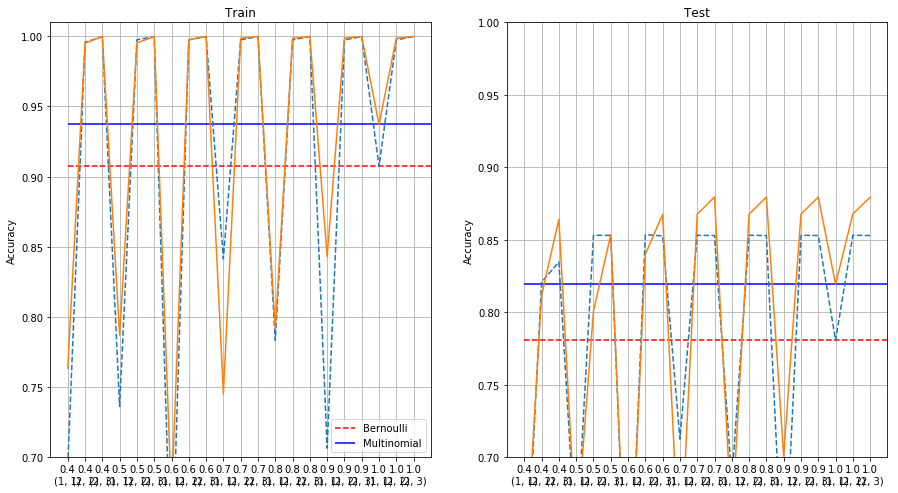

In [33]:
plot_(min_df_train, min_df_test, [''], ['\n'.join([str(a),str(b)]) for a in min_dfs for b in ngrams])

###### Вывод
Отсечение низкочастотных слов дало прирост в точности для всех моделей. Общим оптимальным значением оказалось min_cnt = 1

2.1 Тестирование с различными значениями для alpha в сглаживании

In [91]:
alphas = [0.5, 1, 2, 5]
ngrams = [(1,1), (2,2), (2,3)]
min_df_train = Counter()
min_df_test = Counter()
for alpha in alphas:
    for ngram_range in ngrams:  
        res = test_model('ber', 'ber', ngram_range, 0, 1.0, alpha)
        min_df_train[res[0][0]] = res[0][1]
        min_df_test[res[1][0]] = res[1][1]
        
        res = test_model('mul', 'mul', ngram_range, 0, 1.0, alpha)
        min_df_train[res[0][0]] = res[0][1]
        min_df_test[res[1][0]] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0 alpha: 0.5
Counting without repeats...				Counted in 1.74 sec,
Training Bernoulli					Fitted in 1.10 sec
Predicted for train in 5.13 sec Accuracy: 0.890160
Predicted for test in 4.94 sec Accuracy: 0.775440

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0 alpha: 0.5
Counting with repeats...				Counted in 1.60 sec,
Training Multinomial					Fitted in 0.52 sec
Predicted for train in 4.14 sec Accuracy: 0.921680
Predicted for test in 4.08 sec Accuracy: 0.813120

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0 alpha: 0.5
Counting without repeats...				Counted in 3.53 sec,
Training Bernoulli					Fitted in 8.93 sec
Predicted for train in 8.23 sec Accuracy: 0.997640
Predicted for test in 8.01 sec Accuracy: 0.855320

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0 alpha: 0.5
Counting with repeats...				Counted in 3.05 sec,
Training Multinomial					Fitted in 7.20 sec
Predicted for train in 7.42 sec Accuracy: 0.998440
Predicted for test in 6.38 sec Accuracy: 0.867240

Ng

In [92]:
min_df_train.most_common(5)

[('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0alpha:0.5', 0.99996),
 ('Bernoulli ngram_range:(2, 3) min_cnt:0 max_df:1.0 alpha:0.5', 0.99972),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0alpha:1', 0.99964),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0alpha:2', 0.9992),
 ('Bernoulli ngram_range:(2, 3) min_cnt:0 max_df:1.0 alpha:1', 0.99916)]

In [93]:
min_df_test.most_common(5)

[('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0alpha:2', 0.88296),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0alpha:1', 0.88252),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0alpha:0.5', 0.8816),
 ('Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0alpha:5', 0.8804),
 ('Multinomial ngram_range:(2, 2) min_cnt:0 max_df:1.0alpha:2', 0.87248)]

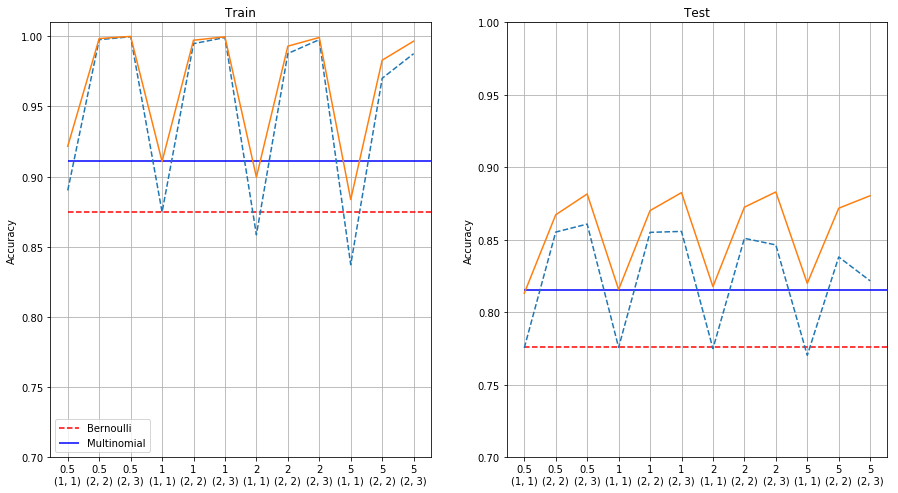

In [96]:
plot_(min_df_train, min_df_test, [''], ['\n'.join([str(a),str(b)]) for a in alphas for b in ngrams])

###### Вывод
Увеличение alpha дает незначительное улучшение результатов

3.Мультиномиальный наивный байес может учитывать или не учитывать частоты слов (во
втором случае достаточно удалить повторяющиеся слова при предобработке). Есть ли
разница в результатах?

In [34]:
ngrams = [(1,1), (2,2), (2,3)]
dupe_train = Counter()
dupe_test = Counter()
for ngram_range in ngrams:  
    res = test_model('mul', 'ber', ngram_range)
    dupe_train[res[0][0]+' uniq'] = res[0][1]
    dupe_test[res[1][0]+' uniq'] = res[1][1]

    res = test_model('mul', 'mul', ngram_range)
    dupe_train[res[0][0]+' dupe'] = res[0][1]
    dupe_test[res[1][0]+' dupe'] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 1.88 sec,
Training Multinomial					Fitted in 0.64 sec
Predicted for train in 4.50 sec Accuracy: 0.940840
Predicted for test in 4.47 sec Accuracy: 0.818760

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 1.75 sec,
Training Multinomial					Fitted in 0.64 sec
Predicted for train in 4.58 sec Accuracy: 0.937280
Predicted for test in 4.42 sec Accuracy: 0.819400

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 3.41 sec,
Training Multinomial					Fitted in 7.05 sec
Predicted for train in 7.43 sec Accuracy: 0.998720
Predicted for test in 6.50 sec Accuracy: 0.867960

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 3.03 sec,
Training Multinomial					Fitted in 7.41 sec
Predicted for train in 7.47 sec Accuracy: 0.998560
Predicted for test in 6.51 sec Accuracy: 0.867840

Ngram range: (2, 3) min_cnt: 0 max_df: 1.0

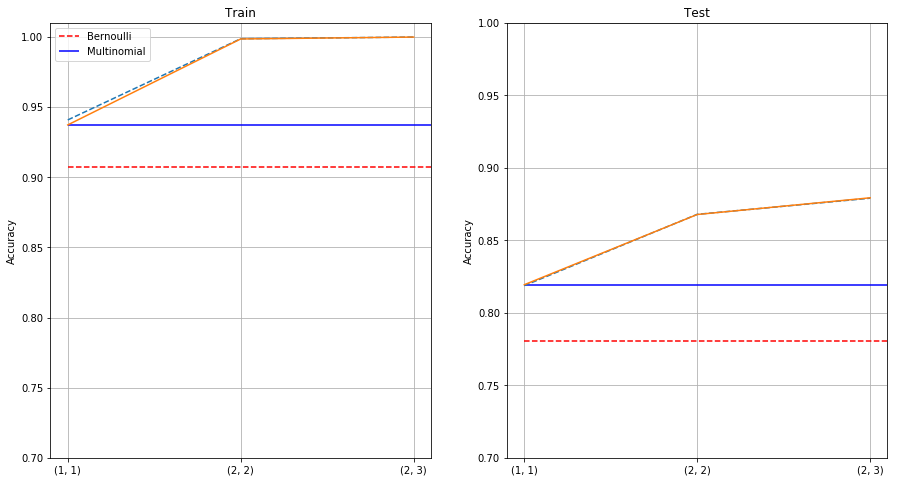

In [35]:
plot_(dupe_train, dupe_test, [''], ngrams)

###### Вывод
Удаление повторяющихся слов для мультиномиальной модели дает незначительное ухудшение результатов для униграммной модели и модели с биграммами и триграммами

4.Предобработка сильно влияет на качество работы классификатора – поэтому имеет
смысл попробовать разные варианты предобработки! Как влияет на качество перевод в
нижний регистр? Стоит ли удалять или оставлять знаки препинания? Заменять все числа на
специальный токен NUMBER?

In [43]:
ngrams = [(1,1), (2,2), (2,3)]
prep_train = Counter()
prep_test = Counter()
for ngram_range in ngrams:  
    res = test_model('ber', 'ber', ngram_range)
    prep_train[res[0][0]+' '] = res[0][1]
    prep_test[res[1][0]+' '] = res[1][1]

    res = test_model('mul', 'mul', ngram_range)
    prep_train[res[0][0]+' '] = res[0][1]
    prep_test[res[1][0]+' '] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 2.08 sec,
Training Bernoulli					Fitted in 1.02 sec
Predicted for train in 7.68 sec Accuracy: 0.919520
Predicted for test in 6.38 sec Accuracy: 0.791600

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 1.99 sec,
Training Multinomial					Fitted in 0.80 sec
Predicted for train in 5.00 sec Accuracy: 0.943960
Predicted for test in 4.76 sec Accuracy: 0.819000

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 3.67 sec,
Training Bernoulli					Fitted in 10.06 sec
Predicted for train in 9.85 sec Accuracy: 0.997920
Predicted for test in 8.37 sec Accuracy: 0.850240

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 3.48 sec,
Training Multinomial					Fitted in 8.84 sec
Predicted for train in 8.41 sec Accuracy: 0.999160
Predicted for test in 7.08 sec Accuracy: 0.867720

Ngram range: (2, 3) min_cnt: 0 max_df: 1.0
Co

In [22]:
def apply_new_prep(pos, neg):
    pos = prep(pos)
    neg = prep(neg)
    
    pos = tokenize(pos)
    neg = tokenize(neg)
    
    return pos, neg

In [45]:
def prep(data):
    new_data = []
    for idx, str in enumerate(data):
        new_str = []
        #str = str.lower()
        for c in str:
            if c in punct:
                new_str.append(' '+c+' ')
            else:
                new_str.append(c)
        new_data.append("".join(new_str))
    return new_data

In [46]:
train_pos_tok, train_neg_tok = apply_new_prep(train_pos, train_neg)
test_pos_tok, test_neg_tok = apply_new_prep(test_pos, test_neg)

In [47]:
ngrams = [(1,1), (2,2), (2,3)]
for ngram_range in ngrams:  
    res = test_model('ber', 'ber', ngram_range)
    prep_train[res[0][0]] = res[0][1]
    prep_test[res[1][0]] = res[1][1]

    res = test_model('mul', 'mul', ngram_range)
    prep_train[res[0][0]] = res[0][1]
    prep_test[res[1][0]] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 2.37 sec,
Training Bernoulli					Fitted in 1.12 sec
Predicted for train in 6.65 sec Accuracy: 0.919520
Predicted for test in 6.51 sec Accuracy: 0.791600

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 2.12 sec,
Training Multinomial					Fitted in 0.86 sec
Predicted for train in 5.44 sec Accuracy: 0.943960
Predicted for test in 5.30 sec Accuracy: 0.819000

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 4.06 sec,
Training Bernoulli					Fitted in 11.63 sec
Predicted for train in 12.05 sec Accuracy: 0.997920
Predicted for test in 8.46 sec Accuracy: 0.850240

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 3.52 sec,
Training Multinomial					Fitted in 8.94 sec
Predicted for train in 8.97 sec Accuracy: 0.999160
Predicted for test in 8.10 sec Accuracy: 0.867720

Ngram range: (2, 3) min_cnt: 0 max_df: 1.0
C

In [48]:
prep_train

Counter({'Bernoulli ngram_range:(1, 1) min_cnt:0 max_df:1.0 ': 0.91952,
         'Multinomial ngram_range:(1, 1) min_cnt:0 max_df:1.0 ': 0.94396,
         'Bernoulli ngram_range:(2, 2) min_cnt:0 max_df:1.0 ': 0.99792,
         'Multinomial ngram_range:(2, 2) min_cnt:0 max_df:1.0 ': 0.99916,
         'Bernoulli ngram_range:(2, 3) min_cnt:0 max_df:1.0 ': 0.99992,
         'Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0 ': 0.99992,
         'Bernoulli ngram_range:(1, 1) min_cnt:0 max_df:1.0': 0.91952,
         'Multinomial ngram_range:(1, 1) min_cnt:0 max_df:1.0': 0.94396,
         'Bernoulli ngram_range:(2, 2) min_cnt:0 max_df:1.0': 0.99792,
         'Multinomial ngram_range:(2, 2) min_cnt:0 max_df:1.0': 0.99916,
         'Bernoulli ngram_range:(2, 3) min_cnt:0 max_df:1.0': 0.99992,
         'Multinomial ngram_range:(2, 3) min_cnt:0 max_df:1.0': 0.99992})

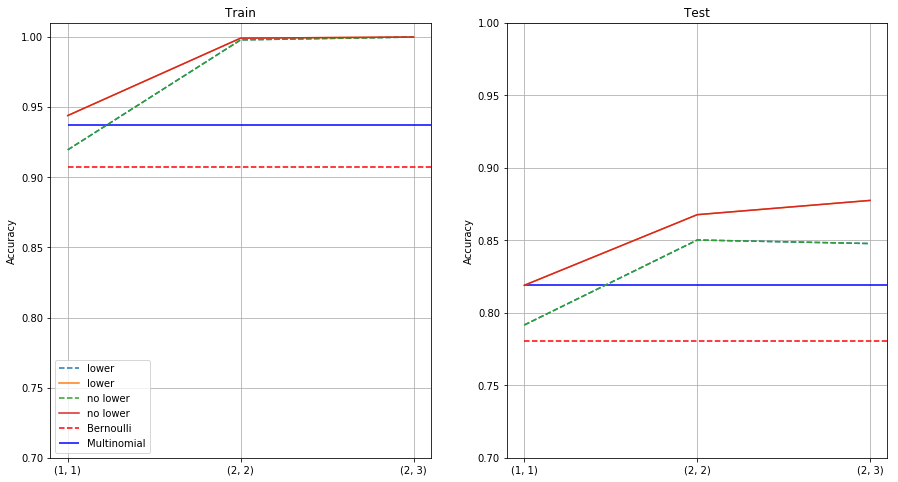

In [49]:
plot_(prep_train, prep_test, ['lower', 'no lower'], ngrams)

###### Вывод
Перевод текста в нижний регистр увеличивает точность на тестовой выборке (повышается обобщающая способность модели - больше одинаковых токенов)

In [50]:
def prep(data):
    new_data = []
    for idx, str in enumerate(data):
        new_str = []
        str = str.lower()
        for c in str:
            if c in punct:
                continue
            else:
                new_str.append(c)
        new_data.append("".join(new_str))
    return new_data

In [51]:
train_pos_tok, train_neg_tok = apply_new_prep(train_pos, train_neg)
test_pos_tok, test_neg_tok = apply_new_prep(test_pos, test_neg)

In [52]:
ngrams = [(1,1), (2,2), (2,3)]
for ngram_range in ngrams:  
    res = test_model('ber', 'ber', ngram_range)
    prep_train[res[0][0]+' no punct'] = res[0][1]
    prep_test[res[1][0]+' no punct'] = res[1][1]

    res = test_model('mul', 'mul', ngram_range)
    prep_train[res[0][0]+' no punct'] = res[0][1]
    prep_test[res[1][0]+' no punct'] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 2.06 sec,
Training Bernoulli					Fitted in 0.48 sec
Predicted for train in 5.62 sec Accuracy: 0.874720
Predicted for test in 5.61 sec Accuracy: 0.775720

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 1.78 sec,
Training Multinomial					Fitted in 0.39 sec
Predicted for train in 4.56 sec Accuracy: 0.910800
Predicted for test in 4.43 sec Accuracy: 0.815680

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 3.85 sec,
Training Bernoulli					Fitted in 8.18 sec
Predicted for train in 9.47 sec Accuracy: 0.994800
Predicted for test in 8.43 sec Accuracy: 0.855120

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 3.39 sec,
Training Multinomial					Fitted in 7.13 sec
Predicted for train in 8.05 sec Accuracy: 0.997240
Predicted for test in 6.93 sec Accuracy: 0.870120

Ngram range: (2, 3) min_cnt: 0 max_df: 1.0
Cou

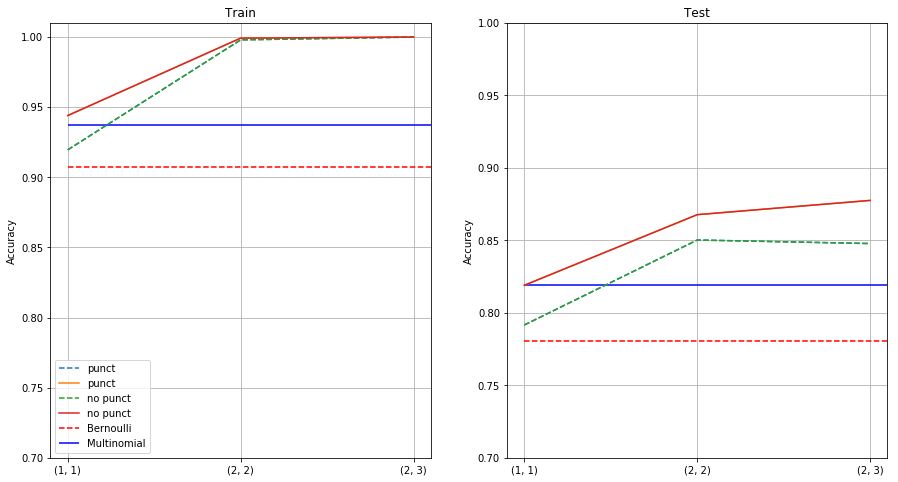

In [53]:
plot_(prep_train, prep_test, ['punct', 'no punct'], ngrams)

###### Вывод
Удаление знаков препинания повышает точность моделей (текст становится менее шумным)

In [54]:
def prep(data):
    new_data = []
    for idx, s in enumerate(data):
        new_str = []
        s = s.lower()
        s = re.sub(r'[0-9]+', 'NUMBER', s)
        for c in s:
            if c in punct:
                new_str.append(' '+c+' ')
            else:
                new_str.append(c)
        new_data.append("".join(new_str))
    return new_data

In [55]:
train_pos_tok, train_neg_tok = apply_new_prep(train_pos, train_neg)
test_pos_tok, test_neg_tok = apply_new_prep(test_pos, test_neg)

In [56]:
ngrams = [(1,1), (2,2), (2,3)]
for ngram_range in ngrams:  
    res = test_model('ber', 'ber', ngram_range)
    prep_train[res[0][0]+' no numbers'] = res[0][1]
    prep_test[res[1][0]+' no numbers'] = res[1][1]

    res = test_model('mul', 'mul', ngram_range)
    prep_train[res[0][0]+' no numbers'] = res[0][1]
    prep_test[res[1][0]+' no numbers'] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 2.27 sec,
Training Bernoulli					Fitted in 1.30 sec
Predicted for train in 6.05 sec Accuracy: 0.904040
Predicted for test in 6.00 sec Accuracy: 0.777120

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 2.04 sec,
Training Multinomial					Fitted in 1.01 sec
Predicted for train in 4.96 sec Accuracy: 0.935440
Predicted for test in 4.96 sec Accuracy: 0.816840

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 4.04 sec,
Training Bernoulli					Fitted in 10.76 sec
Predicted for train in 10.30 sec Accuracy: 0.997480
Predicted for test in 8.41 sec Accuracy: 0.848600

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 3.32 sec,
Training Multinomial					Fitted in 8.60 sec
Predicted for train in 7.88 sec Accuracy: 0.998520
Predicted for test in 7.14 sec Accuracy: 0.863960

Ngram range: (2, 3) min_cnt: 0 max_df: 1.0
C

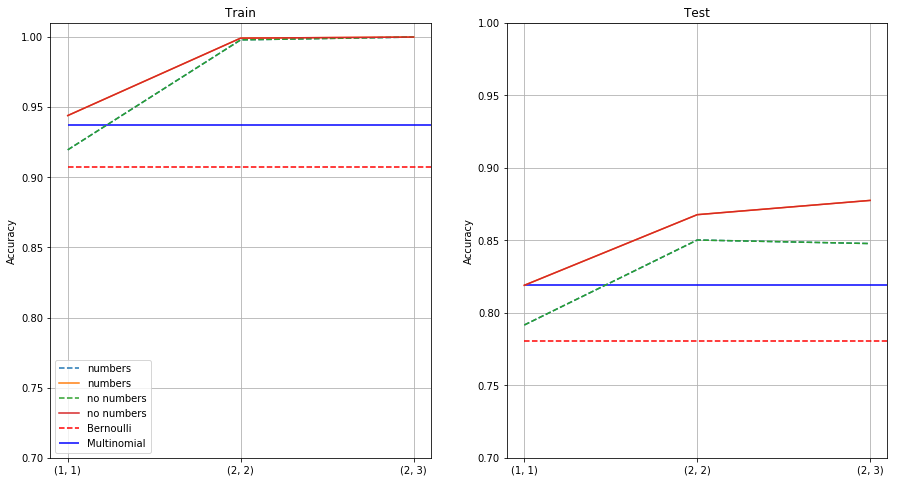

In [57]:
plot_(prep_train, prep_test, ['numbers', 'no numbers'], ngrams)

###### Вывод
Замена чисел на единый токен понижает точность на тестовой выборке (в отзывах встречаются оценки фильма (0/10 или 9/10) что является сильным признаком)

In [64]:
new_punct = punct.replace(')', '').replace('(', '')
new_punct

'!"#$%&\'*+,-./:;<=>?@[\\]^_`{|}~…–—‘“‚„«»'

In [75]:
def prep(data):
    new_data = []
    for idx, str in enumerate(data):
        new_str = []
        str = str.lower()
        for c in str:
            if c in new_punct:
                continue
            else:
                new_str.append(c)
        new_data.append("".join(new_str))
    return new_data

In [76]:
train_pos_tok, train_neg_tok = apply_new_prep(train_pos, train_neg)
test_pos_tok, test_neg_tok = apply_new_prep(test_pos, test_neg)

In [88]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [ ]:
counter = TfidfVectorizer(ngram_range=(1,3))
X = counter.fit_transform([' '.join(txt) for txt in train_pos_tok]+
                          [' '.join(txt) for txt in train_neg_tok])

In [ ]:
model = MultinomialNB()
model.fit(X, [1]*12500+[0]*12500)

In [ ]:
preds = model.predict(X)

In [ ]:
acc = accuracy([1]*12500+[0]*12500, preds)
acc

In [ ]:
X_test = counter.transform([' '.join(txt) for txt in test_pos_tok]+
                          [' '.join(txt) for txt in test_neg_tok])

In [ ]:
preds = model.predict(X_test)

In [ ]:
acc = accuracy([1]*12500+[0]*12500, preds)
acc

In [56]:
ngrams = [(1,1), (2,2), (2,3)]
for ngram_range in ngrams:  
    res = test_model('ber', 'ber', ngram_range)
    prep_train[res[0][0]+' no numbers'] = res[0][1]
    prep_test[res[1][0]+' no numbers'] = res[1][1]

    res = test_model('mul', 'mul', ngram_range)
    prep_train[res[0][0]+' no numbers'] = res[0][1]
    prep_test[res[1][0]+' no numbers'] = res[1][1]

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 2.27 sec,
Training Bernoulli					Fitted in 1.30 sec
Predicted for train in 6.05 sec Accuracy: 0.904040
Predicted for test in 6.00 sec Accuracy: 0.777120

Ngram range: (1, 1) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 2.04 sec,
Training Multinomial					Fitted in 1.01 sec
Predicted for train in 4.96 sec Accuracy: 0.935440
Predicted for test in 4.96 sec Accuracy: 0.816840

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting without repeats...				Counted in 4.04 sec,
Training Bernoulli					Fitted in 10.76 sec
Predicted for train in 10.30 sec Accuracy: 0.997480
Predicted for test in 8.41 sec Accuracy: 0.848600

Ngram range: (2, 2) min_cnt: 0 max_df: 1.0
Counting with repeats...				Counted in 3.32 sec,
Training Multinomial					Fitted in 8.60 sec
Predicted for train in 7.88 sec Accuracy: 0.998520
Predicted for test in 7.14 sec Accuracy: 0.863960

Ngram range: (2, 3) min_cnt: 0 max_df: 1.0
C

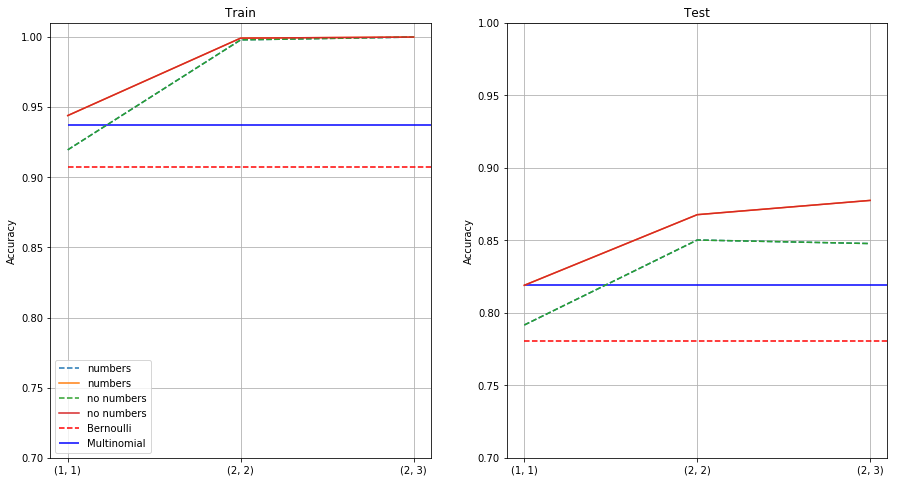

In [57]:
plot_(prep_train, prep_test, ['numbers', 'no numbers'], ngrams)

##### Лучшая модель

In [57]:
def prep(data):
    new_data = []
    for idx, str in enumerate(data):
        new_str = []
        str = str.lower()
        for c in str:
            if c in punct:
                continue
            else:
                new_str.append(c)
        new_data.append("".join(new_str))
    return new_data

In [58]:
train_pos_tok, train_neg_tok = apply_new_prep(train_pos, train_neg)
test_pos_tok, test_neg_tok = apply_new_prep(test_pos, test_neg)

In [29]:
test_model('mul', 'mul', (2,3), 1, 0.7)

Ngram range: (2, 3) min_cnt: 1 max_df: 0.7
Counting with repeats...				Counted in 6.87 sec,
Training Multinomial					Fitted in 3.33 sec
Predicted for train in 12.80 sec Accuracy: 0.992440
Predicted for test in 12.16 sec Accuracy: 0.883680



(('Multinomial ngram_range:(2, 3) min_cnt:1 max_df:0.7', 0.99244),
 ('Multinomial ngram_range:(2, 3) min_cnt:1 max_df:0.7', 0.88368))